## **Project Object:**

To build a detecting tool classifying the text of a person's description of their medical symptom to the correct category(intent), which can be used in applications such as a medical chatbot.

## 1. GPU Setup in Colab

In [ ]:


import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')


Found GPU at: /device:GPU:0


In [ ]:
# In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device

import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 2. Load and analyze data

The dataset used is from kaggle: https://www.kaggle.com/paultimothymooney/medical-speech-transcription-and-intent

This data contains thousands of audio utterances and corresponding transcriptions for common medical symptoms like “knee pain” or “headache”. Only the transcriptions are used in this project.

We can see from below:
* column "phrase" contains transcriptions describing a person's certain medical symptoms
* column "promp" contains their corresponding intents (25 intents in total)


In [ ]:
!pip install transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv('gdrive/My Drive/overview-of-recordings.csv')
data1 = data[['phrase','prompt']]
data1.sample(5)

,phrase,prompt
1453,My ankle joint throbs when I put pressure on m...,Joint pain
6069,My neck hurts me and i can't stand with this pain,Neck pain
2139,I stopped sports because I get Injury from sports,Injury from sports
6392,i have pain like needles in my joints.,Joint pain
5326,My cough is very heavy and I have mucus.,Cough


In [ ]:
df=data1.copy()
df.isna().sum()

,0
phrase,0
prompt,0


In [ ]:
df['prompt'].value_counts()

,count
prompt,
Acne,328
Shoulder pain,320
Joint pain,318
Infected wound,306
Knee pain,305
Cough,293
Feeling dizzy,283
Muscle pain,282
Heart hurts,273


In [ ]:
print('Total number of intents: %d'%(len(df['prompt'].value_counts().index)))

Total number of intents: 25


# EDA

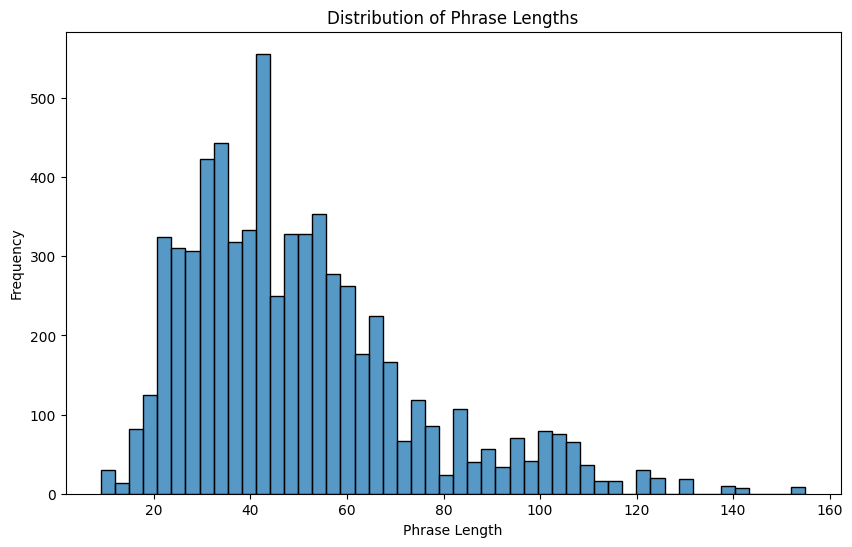

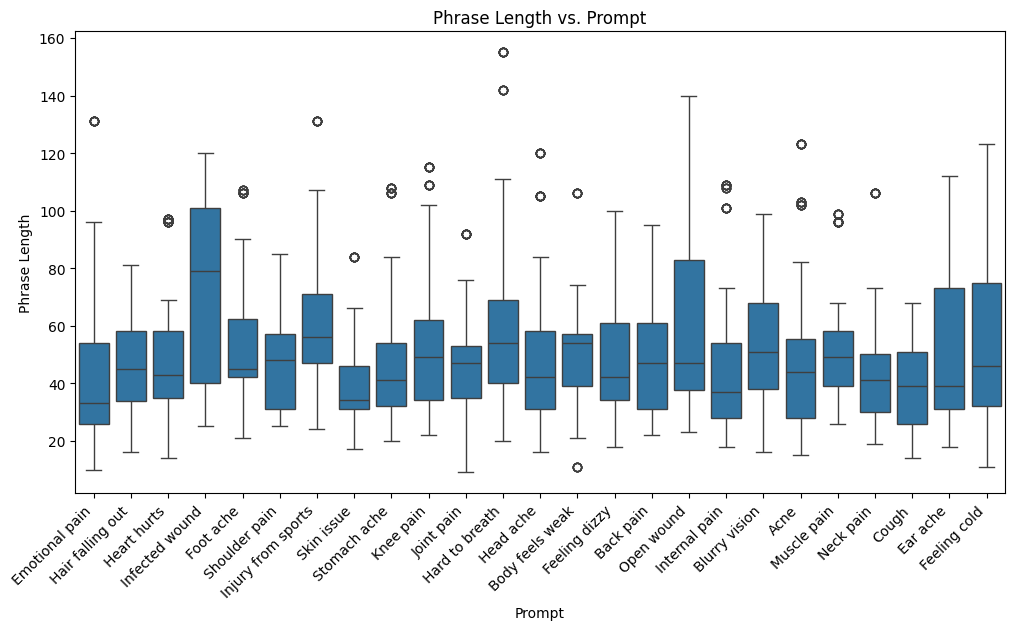

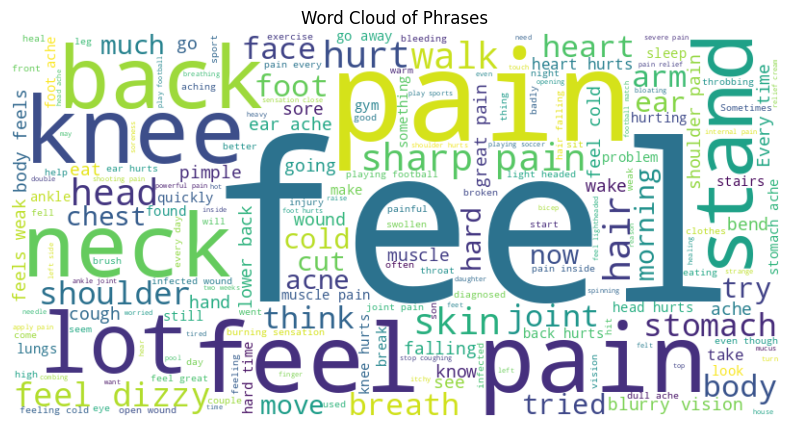

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud



# Distribution of phrase lengths
df['phrase_length'] = df['phrase'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['phrase_length'], bins=50)
plt.title('Distribution of Phrase Lengths')
plt.xlabel('Phrase Length')
plt.ylabel('Frequency')
plt.show()


# Explore the relationship between phrase length and prompt
plt.figure(figsize=(12, 6))
sns.boxplot(x='prompt', y='phrase_length', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Phrase Length vs. Prompt')
plt.xlabel('Prompt')
plt.ylabel('Phrase Length')
plt.show()


text = ' '.join(df['phrase'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Phrases')
plt.show()

In [ ]:

from collections import Counter

for prompt in df['prompt'].unique():
    text = ' '.join(df[df['prompt'] == prompt]['phrase'].astype(str).tolist())
    words = text.lower().split()
    word_counts = Counter(words)
    print(f"Top 10 most frequent words for prompt '{prompt}':")
    for word, count in word_counts.most_common(10):
        print(f"- {word}: {count}")
    print("-" * 20)



Top 10 most frequent words for prompt 'Emotional pain':
- i: 301
- feel: 152
- my: 86
- a: 62
- pain: 59
- when: 53
- sad: 42
- in: 39
- just: 36
- can't: 36
--------------------
Top 10 most frequent words for prompt 'Hair falling out':
- hair: 278
- my: 223
- i: 185
- out: 131
- falling: 111
- is: 93
- a: 91
- in: 83
- when: 70
- of: 69
--------------------
Top 10 most frequent words for prompt 'Heart hurts':
- my: 274
- i: 232
- heart: 193
- pain: 105
- feel: 77
- in: 76
- hurts: 69
- to: 61
- a: 60
- have: 58
--------------------
Top 10 most frequent words for prompt 'Infected wound':
- and: 277
- my: 230
- is: 185
- i: 183
- a: 130
- it: 120
- the: 119
- cut: 108
- wound: 95
- infected: 95
--------------------
Top 10 most frequent words for prompt 'Foot ache':
- i: 223
- my: 204
- foot: 183
- have: 105
- a: 103
- pain: 90
- in: 83
- ache: 63
- the: 55
- walk: 44
--------------------
Top 10 most frequent words for prompt 'Shoulder pain':
- i: 370
- my: 311
- shoulder: 215
- pain: 16

## 3. Split data to train, validation and test sets

I split data to train(70%), validation(10%) and testset (20%) stratified by the variable "intent". After stratification, data for each intent will balanced and data for each set will be proportional to 70%, 10% and 20%. That is crucial for training and testing purposes.

In [ ]:
from sklearn.model_selection import train_test_split

X, sentence_test, y, intent_test = train_test_split(df.phrase, df.prompt, stratify = df.prompt,test_size=0.2, random_state=4612)
sentence_train, sentence_val, intent_train, intent_val = train_test_split(X, y, stratify = y,test_size=0.125, random_state=4612)


In [ ]:
print(f"#examples in training set:{ sentence_train.shape[0]}\n#examples in validation set:{ sentence_val.shape[0]}\n#examples in test set:{ sentence_test.shape[0]}")

#examples in training set:4662
#examples in validation set:666
#examples in test set:1333


## 4. Tokenization and input formatting

I Prepare the input data to the correct format before training as follows:
* tokenizing all sentences
* padding and truncating all sentences to the same length.
* Creating the attention masks which explicitly differentiate real tokens from [PAD] tokens. 0 or 1.
* encoding the label "intent" to numbers. 25 intents to 25 numbers.
* creating DataLoaders for our training, validation and test sets

In [ ]:
# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE =32
VALID_BATCH_SIZE = 64
EPSILON = 1e-08
EPOCHS = 4
LEARNING_RATE = 2e-5
SEED = 1215
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_len = 0
input = []
length=[]
# For every sentence...
for sent in sentence_train:

    # Tokenize the text and add special tokens--`[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input.append(input_ids)
    length.append(len(input_ids))
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    mean_len = sum(length)/len(length)
#39 tokens is the maximum number of tokens in a sentence (transcription). Also, a sentence has 14 tokens on average.
print('Max sentence length:%d \nMean sentence length:%d' % (max_len,mean_len))

Max sentence length:39 
Mean sentence length:14


In [ ]:
# create a function to tokenize sentences.
def tokenize(sentence):
  batch = tokenizer(list(sentence),
                  # is_pretokenized=False,
                  #Pad or truncate all sentences to the same length. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
                  padding=True,
                  truncation=True,
                  return_tensors="pt")
  return batch

In [ ]:
tok_train = tokenize(sentence_train)
tok_val = tokenize(sentence_val)
tok_test = tokenize(sentence_test)


Streaming output truncated to the last 5000 lines.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenize

In [ ]:
from sklearn.preprocessing import LabelEncoder
# encode "intent" to 25 number labels
LE = LabelEncoder()
label_train = torch.tensor((LE.fit_transform(intent_train)))
label_val = torch.tensor((LE.fit_transform(intent_val)))
label_test = torch.tensor((LE.fit_transform(intent_test)))


In [ ]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(tok_train['input_ids'], tok_train['attention_mask'],label_train)
validation_dataset = TensorDataset(tok_val['input_ids'], tok_val['attention_mask'],label_val)
test_dataset = TensorDataset(tok_test['input_ids'], tok_test['attention_mask'],label_test)


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = TRAIN_BATCH_SIZE # Trains with this batch size.
        )

# For validation/test the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            validation_dataset, # The validation samples.
            sampler = SequentialSampler(validation_dataset), # Pull out batches sequentially.
            batch_size = VALID_BATCH_SIZE # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = VALID_BATCH_SIZE
        )

## 5. Train BERT classification model

I use BertForSequenceClassification, a BERT model with an added single linear layer on top for classification. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.



In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

## use pretained base(relatively small) BERT mdoel for sequence classification
#CUDA_LAUNCH_BLOCKING=1
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 25)
model.cuda() # make pytorch run this model on GPU.

## use AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = LEARNING_RATE,
                  eps = EPSILON )

from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * EPOCHS

## Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
import time
import datetime

def format_time(elapsed):
    #Takes a time in seconds and returns a string hh:mm:ss
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Tensorboard')

In [ ]:
# Start the training process:
import random
import torch

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
def train(epochs):
  total_t0 = time.time() # Measure the total training time for the whole run.
  tr_loss = 0
  n_correct = 0
  nb_tr_steps = 0
  nb_tr_examples = 0

  # For each epoch...
  for epoch in range(0, epochs):
      print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
      print('Training...')

      t0 = time.time()     # Measure how long the training epoch takes.
      total_tr_loss = 0
      total_n_correct = 0
      total_nb_tr_examples = 0
      model.train()    # Put the model into training mode

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader, 0):
          # 'batch' contains three pytorch tensors:[0]: input ids, [1]: attention masks, [2]: labels
          input_ids = batch[0].to(device, dtype = torch.long)
          input_mask = batch[1].to(device, dtype = torch.long)
          labels = batch[2].to(device, dtype = torch.long)

          model.zero_grad()       #clear any previously calculated gradients

          outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask)
          loss_function = torch.nn.CrossEntropyLoss()
          loss = loss_function(outputs[0], labels) #`loss` is a Tensor containing a single value
          tr_loss += loss.item() #.item()` function just returns the Python value from the tensor
          total_tr_loss += loss.item()
          big_val, big_idx = torch.max(outputs[0], dim=1)
          n_correct += calcuate_accu(big_idx, labels)
          total_n_correct += calcuate_accu(big_idx, labels)
          nb_tr_steps += 1
          nb_tr_examples+=labels.size(0)
          total_nb_tr_examples+=labels.size(0)

          if step % 20==19:
              loss_step = tr_loss/nb_tr_steps
              accu_step = n_correct/nb_tr_examples # #correct examples/all examples
              print(f"Training Loss per 20 steps(batches): {loss_step}")
              print(f"Training Accuracy per 20 steps(batches): {accu_step}")
              elapsed = format_time(time.time() - t0)    # Calculate elapsed time in minutes.
              # Report progress.
              print('Batch {} of {}.  Elapsed: {:}.'.format(step+1, len(train_dataloader), elapsed))
              #writer.add_scalar('training loss', loss_step, (epoch +1)*len(trainloader) )
              tr_loss = 0;n_correct = 0;nb_tr_steps = 0;nb_tr_examples = 0

          loss.backward() # Perform a backward pass to calculate the gradients.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
          optimizer.step()
          scheduler.step() # Update the learning rate.

    # Calculate the average loss over all of the batches.
      train_loss_per_epoch = total_tr_loss / len(train_dataloader)
      train_accuracy_per_epoch=total_n_correct/total_nb_tr_examples
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("training loss per epoch: {0:.2f}".format(train_loss_per_epoch))
      print("training accuracy per epoch: {0:.2f}".format(train_accuracy_per_epoch))
      print("Training 1 epcoh took: {:}".format(training_time))

In [ ]:
train(epochs = EPOCHS)

======== Epoch 1 / 4 ========
Training...
Training Loss per 20 steps(batches): 3.2095600843429564
Training Accuracy per 20 steps(batches): 0.065625
Batch 20 of 146.  Elapsed: 0:00:06.
Training Loss per 20 steps(batches): 3.1260285139083863
Training Accuracy per 20 steps(batches): 0.075
Batch 40 of 146.  Elapsed: 0:00:10.
Training Loss per 20 steps(batches): 2.9813055276870726
Training Accuracy per 20 steps(batches): 0.1765625
Batch 60 of 146.  Elapsed: 0:00:15.
Training Loss per 20 steps(batches): 2.70634183883667
Training Accuracy per 20 steps(batches): 0.4109375
Batch 80 of 146.  Elapsed: 0:00:19.
Training Loss per 20 steps(batches): 2.4617741227149965
Training Accuracy per 20 steps(batches): 0.5578125
Batch 100 of 146.  Elapsed: 0:00:23.
Training Loss per 20 steps(batches): 2.1630739748477934
Training Accuracy per 20 steps(batches): 0.6921875
Batch 120 of 146.  Elapsed: 0:00:27.
Training Loss per 20 steps(batches): 1.9131096124649047
Training Accuracy per 20 steps(batches): 0.773437

## 6. Test the model on the validation set

In [ ]:
# test the model on the validation set
def valid(model, validation_loader):
  model.eval()
  val_loss = 0
  nb_val_examples = 0
  n_correct = 0
  with torch.no_grad():
    for _, data in enumerate(validation_loader, 0):
      ids = data[0].to(device, dtype = torch.long)
      mask = data[1].to(device, dtype = torch.long)
      targets = data[2].to(device, dtype = torch.long)
      outputs = model(ids, mask)
      loss_function = torch.nn.CrossEntropyLoss()
      loss = loss_function(outputs[0], targets)
      val_loss += loss.item()
      big_val, big_idx = torch.max(outputs[0], dim=1)
      n_correct += calcuate_accu(big_idx, targets)
      nb_val_examples+=targets.size(0)

  val_ave_loss = val_loss/len(validation_loader)
  val_accu = (n_correct*100)/nb_val_examples
  print("Loss on validation/test data: %0.2f" % val_ave_loss)
  print("Accuracy on validation/test data: %0.2f%%" % val_accu)

  return

In [ ]:
valid(model, validation_dataloader)

Loss on validation/test data: 0.15
Accuracy on validation/test data: 99.25%


## 7. Obtain test error

In [ ]:
valid(model, test_dataloader)

Loss on validation/test data: 0.15
Accuracy on validation/test data: 99.25%


## 8. Save the model, tokenizer and labels

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './Documents/intent_detection_healthcare_bert/saved_bert_model_and_tokenizer/'

# Create output directory if needed
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)



Saving model to ./Documents/intent_detection_healthcare_bert/saved_bert_model_and_tokenizer/


('./Documents/intent_detection_healthcare_bert/saved_bert_model_and_tokenizer/tokenizer_config.json',
 './Documents/intent_detection_healthcare_bert/saved_bert_model_and_tokenizer/special_tokens_map.json',
 './Documents/intent_detection_healthcare_bert/saved_bert_model_and_tokenizer/vocab.txt',
 './Documents/intent_detection_healthcare_bert/saved_bert_model_and_tokenizer/added_tokens.json')

In [ ]:
df_label = pd.DataFrame(tuple(zip(range(25),LE.classes_)), columns=['id','intent'])
df_label.to_pickle('./Documents/intent_detection_healthcare_bert/saved_bert_model_and_tokenizer/df_label.pkl')

In [ ]:
# Copy the model files to a directory in Google Drive.
!cp -r ./Documents/intent_detection_healthcare_bert/saved_bert_model_and_tokenizer/ "gdrive/My Drive/"

## 9. Prepare the model for deployment
* Load the saved model, tokenizer and labels
* Create a medical_symptom_detector function with the loaded model, tokenizer and labels, which helps predict the medical intent of a medical message.
* test the detector on an unseen example

In [ ]:
#### load the model and build the detector for deployment
!pip install transformers
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification

input_dir = 'gdrive/My Drive/saved_bert_model_and_tokenizer/'

loaded_model = BertForSequenceClassification.from_pretrained(input_dir)
loaded_model.eval()
loaded_tokenizer = BertTokenizer.from_pretrained(input_dir)
loaded_df_label = pd.read_pickle('gdrive/My Drive/saved_bert_model_and_tokenizer/df_label.pkl')



In [ ]:
# test the model on an unseen example

def medical_symptom_detector(intent):

  pt_batch = loaded_tokenizer(
  intent,
  padding=True,
  truncation=True,
  return_tensors="pt")

  pt_outputs = loaded_model(**pt_batch)
  __, id = torch.max(pt_outputs[0], dim=1)
  prediction = loaded_df_label.iloc[[id.item()]]['intent'].item()
  print('You may have a medical condition: %s. '%(prediction))
  return

In [ ]:
input = 'I am having pain in my brain'
medical_symptom_detector(input)

You may have a medical condition: Head ache. 
